In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from mlxtend.plotting import plot_decision_regions

In [2]:
df = pd.read_csv("covid_with_dummies.csv")

In [3]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)

In [4]:
df

,death,age_new,USMER_2,SEX_M,PATIENT_TYPE_1,PNEUMONIA_1.0,PREGNANT_1.0,DIABETES_1.0,COPD_1.0,ASTHMA_1.0,INMSUPR_1.0,HIPERTENSION_1.0,OTHER_DISEASE_1.0,CARDIOVASCULAR_1.0,OBESITY_1.0,RENAL_CHRONIC_1.0,TOBACCO_1.0,classification_P
0,1,2,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
1,1,2,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0,0
2,1,2,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021972,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1021973,0,2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1021974,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1021975,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.death.value_counts(normalize=True)

0    0.926948
1    0.073052
Name: death, dtype: float64

In [6]:
df.death.value_counts()

0    947320
1     74657
Name: death, dtype: int64

In [7]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score

In [8]:
def scores(y_train,y_val,x_train,x_val,model):
    predicted_train = model.predict(x_train)
    predicted_val = model.predict(x_val)
    precision = [round(precision_score(y_train,predicted_train)*100,2),round(precision_score(y_val,predicted_val)*100,2)]
    recall = [round(recall_score(y_train,predicted_train)*100,2),round(recall_score(y_val,predicted_val)*100,2)]
    f1 = [round(f1_score(y_train,predicted_train)*100,2),round(f1_score(y_val,predicted_val)*100,2)]
    return pd.DataFrame({"Dataset":["Train","Validation"],
                        "Precision": precision,
                        "Recall":recall,
                        "F1 Score":f1,
                        "Accuracy":[round(model.score(x_train, y_train) * 100, 2),round(model.score(x_val, y_val) * 100, 2)]})

<font color="blue">Dengesiz bir veri seti olduğu için sampling uygulayacağım.
  

In [9]:
def print_confusion_matrix(confusion_matrix, figsize = [12,8], fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=["Alive",'Dead'], columns=["Alive",'Dead'])
    fig = plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    return fig

In [10]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

<font color="PURPLE"> 1. RANDOM OVERSAMPLING

In [11]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X,y)

In [12]:
Counter(y_resampled)

Counter({1: 947320, 0: 947320})

In [13]:
X_train, x_test, Y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.25, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
# Logistic Regression
logreg_ros = LogisticRegression(solver='liblinear').fit(x_train, y_train)
ros_logreg = scores(y_train,y_val,x_train,x_val,logreg_ros)
ros_logreg

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,88.83,91.94,90.36,90.19
1,Validation,88.77,91.92,90.32,90.16


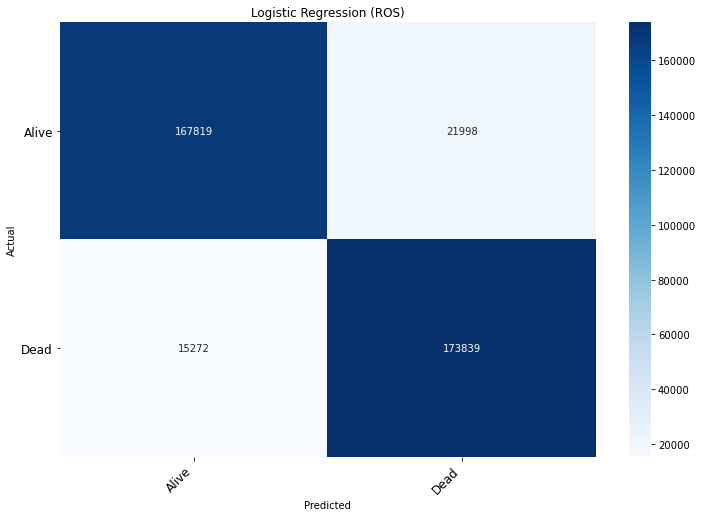

In [16]:
cm = print_confusion_matrix(confusion_matrix(y_val, logreg_ros.predict(x_val)))
plt.title("Logistic Regression (ROS)");

In [17]:
# Support Vector classifier
svc_ros = LinearSVC(dual=False).fit(x_train, y_train)
ros_svc = scores(y_train,y_val,x_train,x_val,svc_ros)
ros_svc

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,88.35,91.32,89.81,89.63
1,Validation,88.29,91.34,89.79,89.64


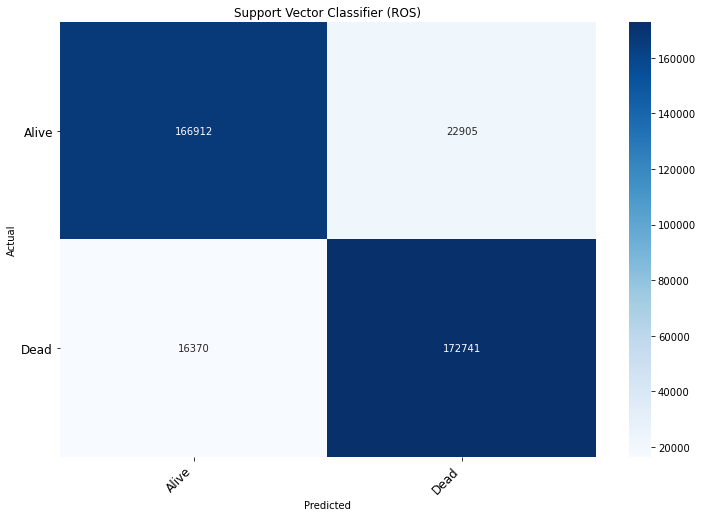

In [18]:
cm = print_confusion_matrix(confusion_matrix(y_val, svc_ros.predict(x_val)))
plt.title("Support Vector Classifier (ROS)");

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Random forest classifier
random_forest_ros = RandomForestClassifier().fit(x_train, y_train)
ros_rf = scores(y_train,y_val,x_train,x_val,random_forest_ros)
ros_rf

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,88.74,94.96,91.75,91.45
1,Validation,88.43,94.90,91.55,91.26


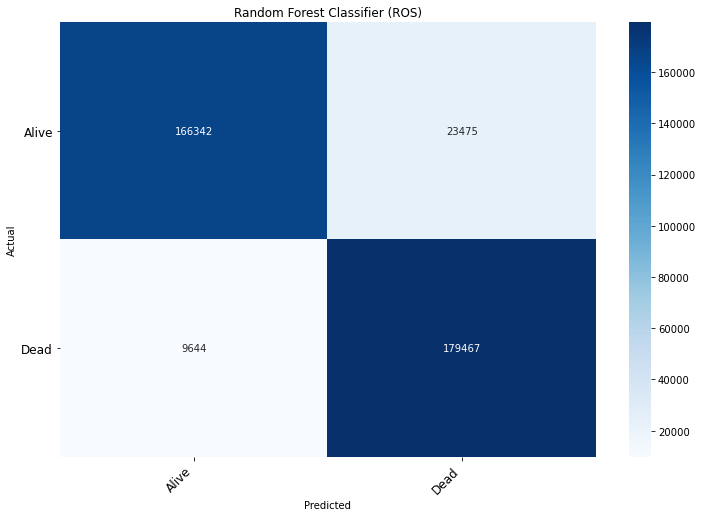

In [21]:
cm = print_confusion_matrix(confusion_matrix(y_val, random_forest_ros.predict(x_val)))
plt.title("Random Forest Classifier (ROS)");

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
# KNN
# knn_ros = KNeighborsClassifier().fit(x_train, y_train)
# ros_knn = scores(y_train,y_val,x_train,x_val,knn_ros)
# ros_knn

In [24]:
# cm = print_confusion_matrix(confusion_matrix(y_val, knn_ros.predict(x_val)))

In [25]:
# Gaussian Naive Bayes
gaussian_ros = GaussianNB().fit(x_train, y_train)  
ros_gaussian = scores(y_train,y_val,x_train,x_val,gaussian_ros)
ros_gaussian

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,86.42,86.54,86.48,86.46
1,Validation,86.39,86.61,86.50,86.51


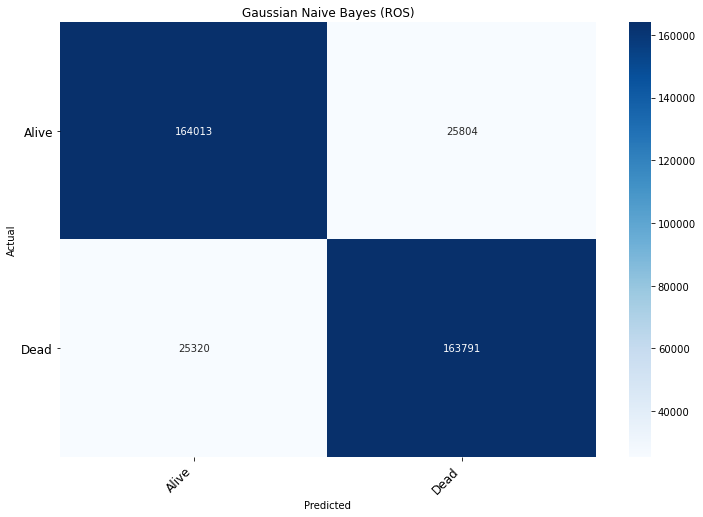

In [26]:
cm = print_confusion_matrix(confusion_matrix(y_val, gaussian_ros.predict(x_val)))
plt.title("Gaussian Naive Bayes (ROS)");

In [27]:
from sklearn.linear_model import Perceptron

In [28]:
# Perceptron
perceptron_ros = Perceptron().fit(x_train, y_train)
ros_perceptron = scores(y_train,y_val,x_train,x_val,perceptron_ros)
ros_perceptron

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,89.79,86.69,88.21,88.41
1,Validation,89.75,86.74,88.22,88.44


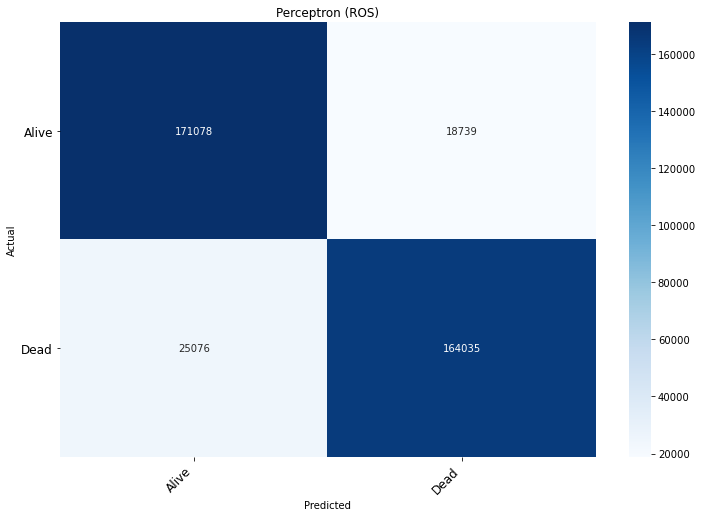

In [29]:
cm = print_confusion_matrix(confusion_matrix(y_val, perceptron_ros.predict(x_val)))
plt.title("Perceptron (ROS)");

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
# Decision Tree
decision_tree_ros = DecisionTreeClassifier().fit(x_train, y_train)
ros_decision_tree = scores(y_train,y_val,x_train,x_val,decision_tree_ros)
ros_decision_tree

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,88.75,94.95,91.75,91.45
1,Validation,88.46,94.88,91.56,91.27


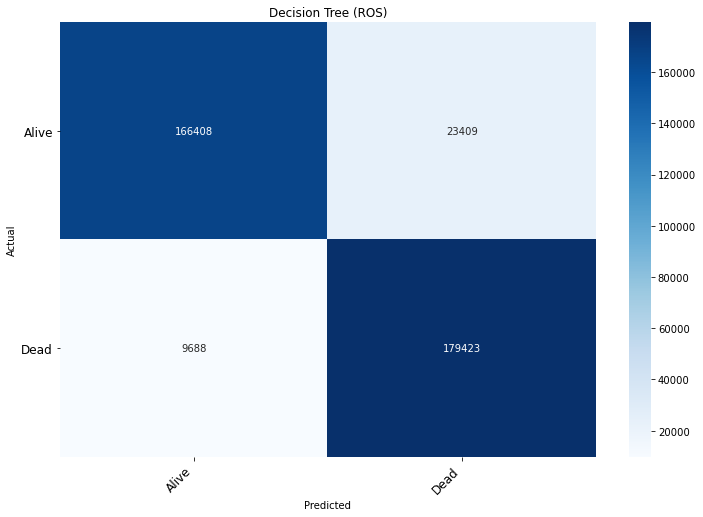

In [51]:
cm = print_confusion_matrix(confusion_matrix(y_val, decision_tree_ros.predict(x_val)))
plt.title("Decision Tree (ROS)");
plt.savefig("decision_tree_ros.png")

In [33]:
# XGBoost
xgb_ros = XGBClassifier().fit(x_train, y_train)
ros_xgb = scores(y_train,y_val,x_train,x_val,xgb_ros)
ros_xgb

,Dataset,Precision,Recall,F1 Score,Accuracy
0,Train,88.28,94.83,91.43,91.11
1,Validation,88.17,94.78,91.36,91.05


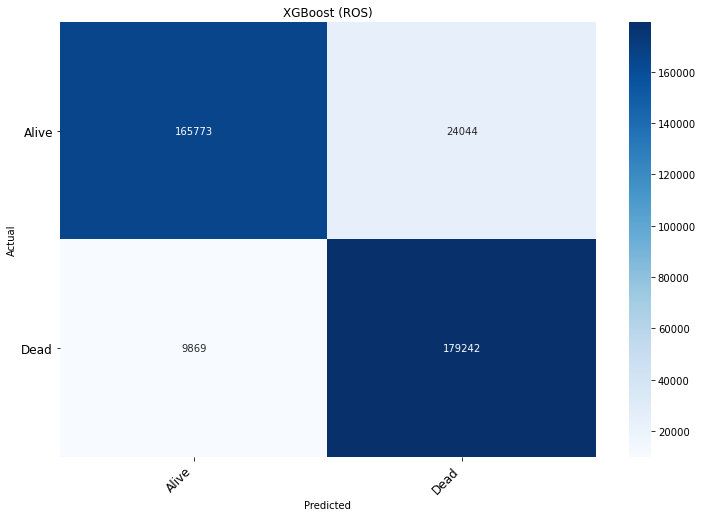

In [48]:
cm = print_confusion_matrix(confusion_matrix(y_val, xgb_ros.predict(x_val)))
plt.title("XGBoost (ROS)");

In [35]:
dataframes = [ros_logreg,ros_svc,ros_rf,ros_gaussian,ros_perceptron,ros_decision_tree,ros_xgb]
model = ["Logistic Regression","SVC","Random Forest","GaussianNB","Perceptron","Decision Tree","XGBoost"]
precisions = []
recalls = []
f1_scores= []
accuracies = []
for dataframe in dataframes:
    precisions.append(dataframe.iloc[1,1])
    recalls.append(dataframe.iloc[1,2])
    f1_scores.append(dataframe.iloc[1,3])
    accuracies.append(dataframe.iloc[1,4])
models_with_ROS = pd.DataFrame({"Model":model, "Precision":precisions,"Recall":recalls,"F1 Score":f1_scores,"Accuracy":accuracies})
models_with_ROS.set_index("Model").sort_values(by="F1 Score",ascending=False)

,Precision,Recall,F1 Score,Accuracy
Model,,,,
Decision Tree,88.46,94.88,91.56,91.27
Random Forest,88.43,94.90,91.55,91.26
XGBoost,88.17,94.78,91.36,91.05
Logistic Regression,88.77,91.92,90.32,90.16
SVC,88.29,91.34,89.79,89.64
Perceptron,89.75,86.74,88.22,88.44
GaussianNB,86.39,86.61,86.50,86.51


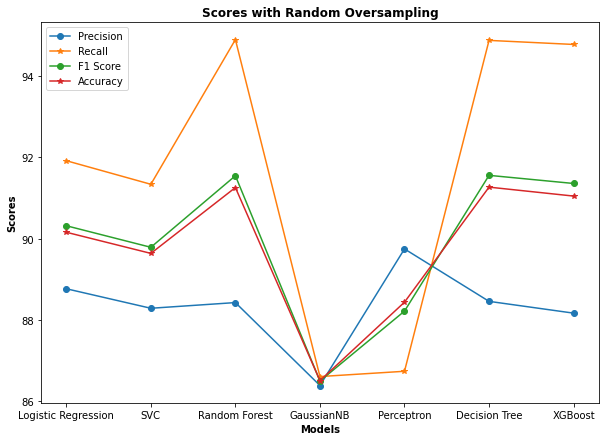

In [50]:
plt.figure(figsize=[10,7])
plt.plot(models_with_ROS.Model,models_with_ROS.Precision,marker = 'o')
plt.plot(models_with_ROS.Model,models_with_ROS.Recall,marker = '*')
plt.plot(models_with_ROS.Model,models_with_ROS["F1 Score"],marker = 'o')
plt.plot(models_with_ROS.Model,models_with_ROS["Accuracy"],marker = '*')
plt.legend(["Precision","Recall","F1 Score","Accuracy"])
plt.title("Scores with Random Oversampling",weight="bold")
plt.xlabel("Models",weight="bold")
plt.ylabel("Scores",weight="bold")
plt.savefig("scores_ros.png")

In [77]:
new_df = pd.DataFrame({"Logistic Regression":models_with_ROS.iloc[0,:] ,
                       "SVC":models_with_ROS.iloc[1,:],
                       "Random Forest":models_with_ROS.iloc[2,:],
                       "GaussianNB":models_with_ROS.iloc[3,:],
                       "Perceptron":models_with_ROS.iloc[4,:],
                       "Decision Tree":models_with_ROS.iloc[5,:],
                       "XGBoost":models_with_ROS.iloc[6,:]})

In [79]:
new_df = new_df.iloc[1:,:]

In [80]:
new_df

,Logistic Regression,SVC,Random Forest,GaussianNB,Perceptron,Decision Tree,XGBoost
Precision,88.77,88.29,88.43,86.39,89.75,88.46,88.17
Recall,91.92,91.34,94.9,86.61,86.74,94.88,94.78
F1 Score,90.32,89.79,91.55,86.5,88.22,91.56,91.36
Accuracy,90.16,89.64,91.26,86.51,88.44,91.27,91.05


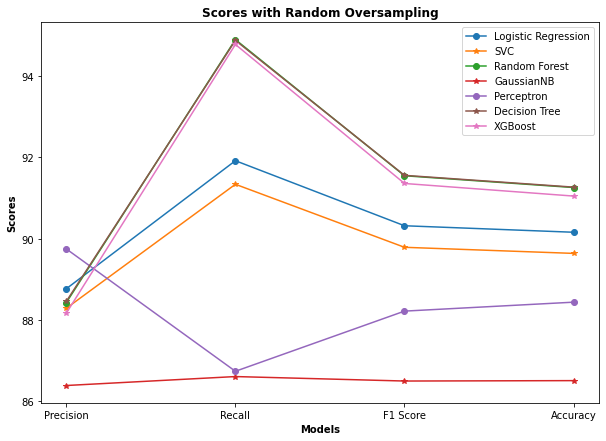

In [82]:
plt.figure(figsize=[10,7])
plt.plot(new_df.index,new_df["Logistic Regression"],marker = 'o')
plt.plot(new_df.index,new_df["SVC"],marker = '*')
plt.plot(new_df.index,new_df["Random Forest"],marker = 'o')
plt.plot(new_df.index,new_df["GaussianNB"],marker = '*')
plt.plot(new_df.index,new_df["Perceptron"],marker = 'o')
plt.plot(new_df.index,new_df["Decision Tree"],marker = '*')
plt.plot(new_df.index,new_df["XGBoost"],marker = '*')

plt.legend(["Logistic Regression","SVC","Random Forest","GaussianNB","Perceptron","Decision Tree","XGBoost"])
plt.title("Scores with Random Oversampling",weight="bold")
plt.xlabel("Models",weight="bold")
plt.ylabel("Scores",weight="bold")
plt.savefig("scores_random_oversampling_yeni.png")

### <font color="blue"> Random over sampling ile veri setimizin dengesini sağladıktan sonra model denemelerimin içinde en iyisi Decision Tree. Şimdi Decision Tree için cross validation uyguluyorum.

In [37]:
decision_tree_last = DecisionTreeClassifier().fit(X_train, Y_train)

In [38]:
from sklearn.model_selection import cross_val_score

scores_accuracy = cross_val_score(decision_tree_last, X_train, Y_train, cv=5, scoring = "accuracy")

print("Scores:", scores_accuracy)
print("Mean:", scores_accuracy.mean())
print("Standard Deviation:", scores_accuracy.std())

Scores: [0.91264189 0.91335772 0.91288241 0.91319909 0.91251625]
Mean: 0.9129194727226114
Standard Deviation: 0.0003197715098846078


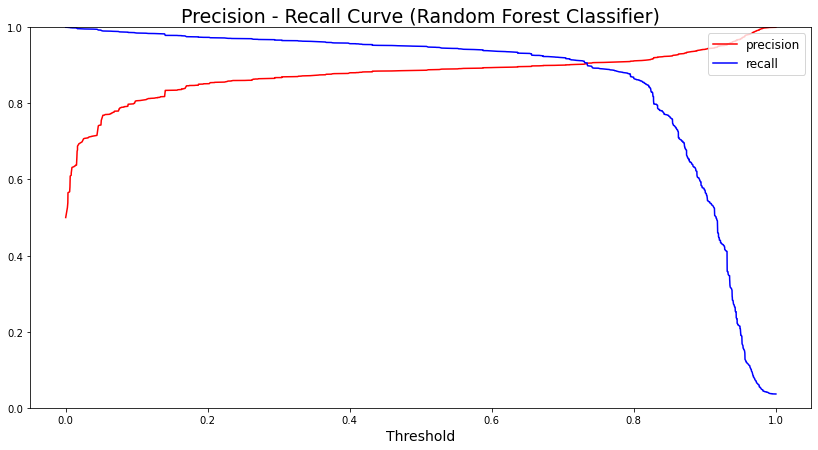

In [39]:
from sklearn.metrics import precision_recall_curve

y_scores = decision_tree_last.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision")
    plt.plot(threshold, recall[:-1], "b", label="recall")
    plt.title("Precision - Recall Curve (Random Forest Classifier)",fontsize=19)
    plt.xlabel("Threshold", fontsize=14)
    plt.legend(loc="upper right", fontsize=12)
    plt.ylim([0, 1])

plt.figure(figsize=[14,7])
plot_precision_and_recall(precision, recall, threshold)

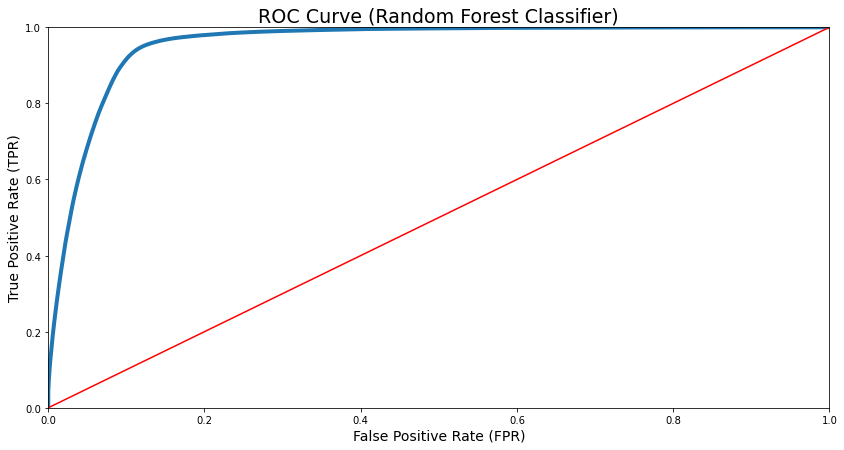

In [40]:
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=4, label=label)
    plt.plot([0, 1], [0, 1], 'r')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC Curve (Random Forest Classifier)",fontsize=19)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)

plt.figure(figsize=[14,7])
plot_roc_curve(false_positive_rate, true_positive_rate)

In [41]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC Score:", r_a_score)

ROC-AUC Score: 0.9561799958148015


<font color="blue"> Artık modelimize karar verdik şimdi test veri setimiz üzerinde modelimizi test edelim.

In [42]:
test_pred = decision_tree_last.predict(x_test.values)

C:\Users\MERVE\anaconda3\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [44]:
print("Precision:", round(precision_score(y_test,test_pred)*100,2))
print("Recall:", round(recall_score(y_test,test_pred)*100,2))
print("F1 Score:", round(f1_score(y_test,test_pred)*100,2))
print("Accuracy:", round(decision_tree_last.score(x_test, y_test) * 100, 2))

Precision: 88.6
Recall: 94.87
F1 Score: 91.63
Accuracy: 91.33


In [45]:
from sklearn.metrics import log_loss

print("Log-Loss: {:2.3f}".format(log_loss(y_test, decision_tree_last.predict_proba(x_test))))

Log-Loss: 0.276


In [46]:
from joblib import dump, load

In [47]:
dump(decision_tree_last,"decision_tree_oversampling.pkl")

['decision_tree_oversampling.pkl']

In [72]:
def make_confusion_matrix(model, threshold=0.5): # Ön tanımlı threshold değeri
    pred = (model.predict_proba(x_test) >= threshold)[:, 1]
    mat = confusion_matrix(y_test, pred)
    plt.figure(figsize=[10,7])
    sns.heatmap(mat, cmap=plt.cm.Blues, annot=True, square=True,fmt=".0f", 
                xticklabels=["LIVE","DIED"],yticklabels=["LIVE","DIED"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    print(f"Precision for DEATH: {round(precision_score(y_test,pred)*100,2)}")
    print(f"Recall for DEATH: {round(recall_score(y_test,pred)*100,2)}")
    print(f"F1 Score: {round(f1_score(y_test,model.predict(x_test))*100,2)}")
    print(f"Accuracy: {round(((mat[0,0] +mat[1,1])/(mat[0,0]+mat[1,1]+mat[0,1]+mat[1,0]))*100,2)}");
    print("Threshold:", threshold);

Precision for DEATH: 0.908
Recall for DEATH: 0.888
Accuracy: 0.8991


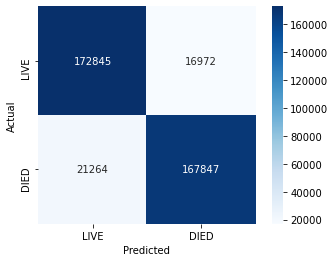

In [53]:
make_confusion_matrix(decision_tree_last,threshold=0.77)

Precision for DEATH: 89.87
Recall for DEATH: 91.9
F1 Score: 91.63
Accuracy: 90.77


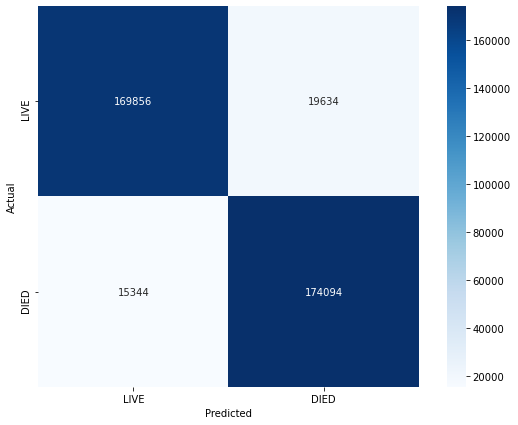

In [67]:
make_confusion_matrix(decision_tree_last,threshold=0.70)

Precision for DEATH: 89.8
Recall for DEATH: 92.11
F1 Score: 91.63
Accuracy: 90.83
Threshold: 0.68


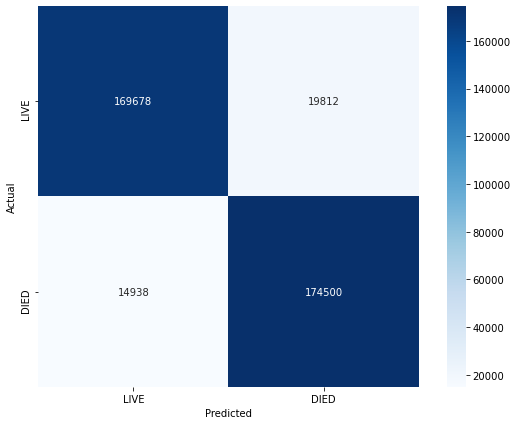

In [73]:
make_confusion_matrix(decision_tree_last,threshold=0.68)

Precision for DEATH: 89.54
Recall for DEATH: 92.98
F1 Score: 91.63
Accuracy: 91.06


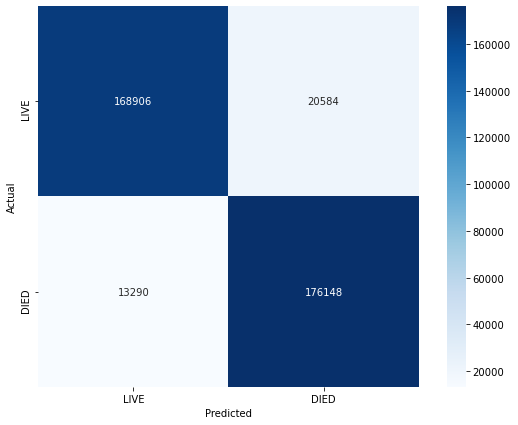

In [69]:
make_confusion_matrix(decision_tree_last,threshold=0.65)